## K Mean Clustering Mobility Data

In [ ]:
! pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=e6cd3f6147d39ac3ed01021fa1488f9d91e14283ee5ec362251924f7122d4c86
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [ ]:
## for data
import numpy as np
import pandas as pd
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for geospatial
import folium
import geopy
## for machine learning
from sklearn import preprocessing, cluster
import scipy
## for deep learning
import minisom

In [ ]:
tj = pd.read_csv('/content/all_trajectories.csv')
tj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250356 entries, 0 to 250355
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  250356 non-null  int64  
 1   index       250356 non-null  int64  
 2   tripIndex   250356 non-null  int64  
 3   lat         250356 non-null  float64
 4   lon         250356 non-null  float64
 5   time        250356 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 11.5 MB


In [ ]:
city = "Rome"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Roma, Roma Capitale, Lazio, Italia
[lat, long]: [41.8933203, 12.4829321]


In [ ]:
X = tj[["lat","lon"]]
max_k = 50
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
      model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
      model.fit(X)
      distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot


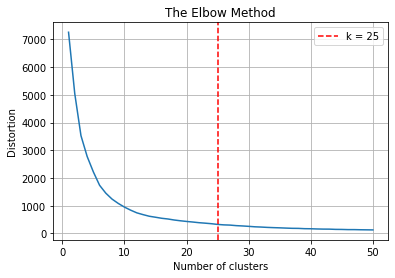

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
#plt.savefig('Elbow_method_1.png')
plt.show()


In [ ]:
k = 25
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = tj[["lat","lon"]]
## clustering
tj_X = X.copy()
tj_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     tj_X.drop("cluster", axis=1).values)
tj_X["centroids"] = 0
for i in closest:
    tj_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
tj[["cluster","centroids"]] = tj_X[["cluster","centroids"]]
tj.sample(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Unnamed: 0,index,tripIndex,lat,lon,time,cluster,centroids
17160,17160,1864,105536,41.897040,12.564313,2997,1,0
52241,52241,2247,300420,41.854300,12.729011,1031,18,0
120359,120359,5205,50657,41.862621,12.692706,1252,18,0
66765,66765,3356,180682,41.865038,12.643244,1718,18,0
18265,18265,2969,10088,41.945798,12.473132,478,22,0


In [ ]:
tj.head()

,Unnamed: 0,index,tripIndex,lat,lon,time,cluster,centroids
0,0,0,349,41.904218,12.679084,0,18,0
1,1,1,349,41.898969,12.678453,55,18,0
2,2,2,349,41.901686,12.678275,645,18,0
3,3,3,349,41.896203,12.676946,1291,18,0
4,4,4,349,41.895846,12.675373,1292,18,0


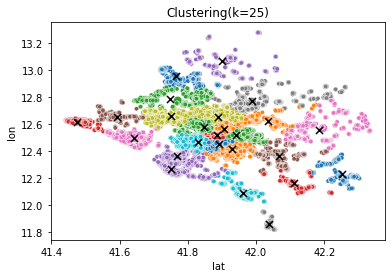

In [ ]:
## plot
fig, ax = plt.subplots()

sns.scatterplot(x="lat", y="lon", data=tj, 
                palette=sns.color_palette('tab10',k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")
#sns.set(rc={"figure.dpi":1000, 'savefig.dpi':1000})
#plt.savefig("Clusters_25.png", dpi = 1000)

Text(0.5, 1.0, 'Clustering (k=25)')

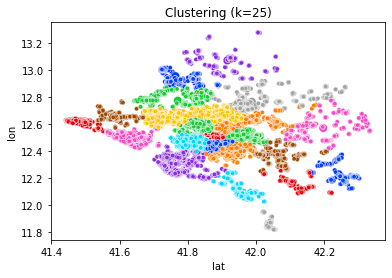

In [ ]:
k = tj["cluster"].nunique()
sns.scatterplot(x="lat", y="lon", data=tj, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False).set_title('Clustering (k='+str(k)+')')
#plt.savefig("Cluster_2.png", dpi = 500)

In [ ]:
x, y = "lat", "lon"
color = "cluster"
marker = "centroids"
size = 'tripIndex'
data = tj.copy()
## create color column
lst_elements = sorted(list(tj[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]],
           color=row["color"], fill=False,
           radius=row["size"]).add_to(map_), axis=1)

## add centroids marker
lst_elements = sorted(list(tj[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_

In [ ]:
from IPython.display import display

In [ ]:
display(map_)

## Clusterin the trees
### K-Mean Clustering

In [ ]:
tr = pd.read_csv('/content/New_punti_with_lon_lat.csv')
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410974 entries, 0 to 410973
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  410974 non-null  int64  
 1   DESCRIZION  408148 non-null  object 
 2   MUNICIPIO   410974 non-null  float64
 3   CODICE_COM  410974 non-null  int64  
 4   CODICE_PRO  410974 non-null  int64  
 5   SCALA_NOMI  410974 non-null  int64  
 6   DATA        410974 non-null  object 
 7   CARTA       410974 non-null  int64  
 8   DITTA       410974 non-null  float64
 9   FLAG_LIM    66499 non-null   float64
 10  IDENTIFICA  410974 non-null  float64
 11  CODICE      410974 non-null  object 
 12  CODICE_DGC  248485 non-null  float64
 13  geometry    410974 non-null  object 
 14  lon         410974 non-null  float64
 15  lat         410974 non-null  float64
dtypes: float64(7), int64(5), object(4)
memory usage: 50.2+ MB


In [ ]:
city = "Rome"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Roma, Roma Capitale, Lazio, Italia
[lat, long]: [41.8933203, 12.4829321]


In [ ]:
X = tr[["lat","lon"]]
max_k = 50
## iterations
distortions = [] 
for i in range(1, max_k+1):
  print(i)
  if len(X) >= i:
    model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    model.fit(X)
    distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


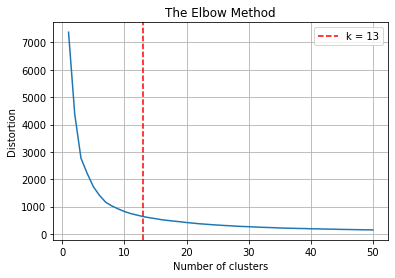

In [ ]:
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.savefig('Elbow_method_2.png', dpi = 500)
plt.show()

In [ ]:
k = 13
model = cluster.KMeans(n_clusters=k, init='k-means++')
X_1 = tr[["lat","lon"]]
## clustering
tr_X = X_1.copy()
tr_X["cluster"] = model.fit_predict(X_1)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     tr_X.drop("cluster", axis=1).values)
tr_X["centroids"] = 0
for i in closest:
    tr_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
tr[["cluster","centroids"]] = tr_X[["cluster","centroids"]]
tr.sample(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Unnamed: 0,DESCRIZION,MUNICIPIO,CODICE_COM,CODICE_PRO,SCALA_NOMI,DATA,CARTA,DITTA,FLAG_LIM,IDENTIFICA,CODICE,CODICE_DGC,geometry,lon,lat,cluster,centroids
140193,140193,Albero isolato,19.0,91,58,5000,25/05/02,374051,100.0,NaN,4.000000e+11,030101S,14646.0,POINT (12.386843596498798 41.93831550600359),12.386844,41.938316,12,0
145909,145909,Albero isolato in area urbana,18.0,91,58,5000,25/04/02,374104,100.0,NaN,4.000000e+11,030108,11141.0,POINT (12.431381857712347 41.89430107420521),12.431382,41.894301,7,0
292644,292644,Albero isolato,18.0,91,58,5000,25/04/02,373082,100.0,NaN,4.000000e+11,030101S,137.0,POINT (12.302483301032657 41.905237472185185),12.302483,41.905237,12,0
23545,23545,Albero isolato,20.0,91,58,5000,25/04/02,374022,100.0,0.0,4.000000e+11,030101S,16979.0,POINT (12.465091692230207 41.96606903338934),12.465092,41.966069,9,0
215493,215493,Albero isolato in area urbana,9.0,91,58,5000,25/05/02,374114,100.0,NaN,4.000000e+11,030108,NaN,POINT (12.518737671226683 41.87532955046839),12.518738,41.875330,11,0


In [ ]:
import mpl_toolkits


In [ ]:
! pip3 install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 30.5 MB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 
     |████████████████████████████████| 30.5 MB 1.4 MB/s 
     |████████████████████████████████| 6.3 MB 64.3 MB/s 


In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm


In [ ]:
def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(tr['lat'])
    lon = list(tr['lon'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(tr['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = tr.loc[tr['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['lon']), list(df['lat']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

In [ ]:
k

13

(<Figure size 1296x1080 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2af263090>,
       dtype=object))

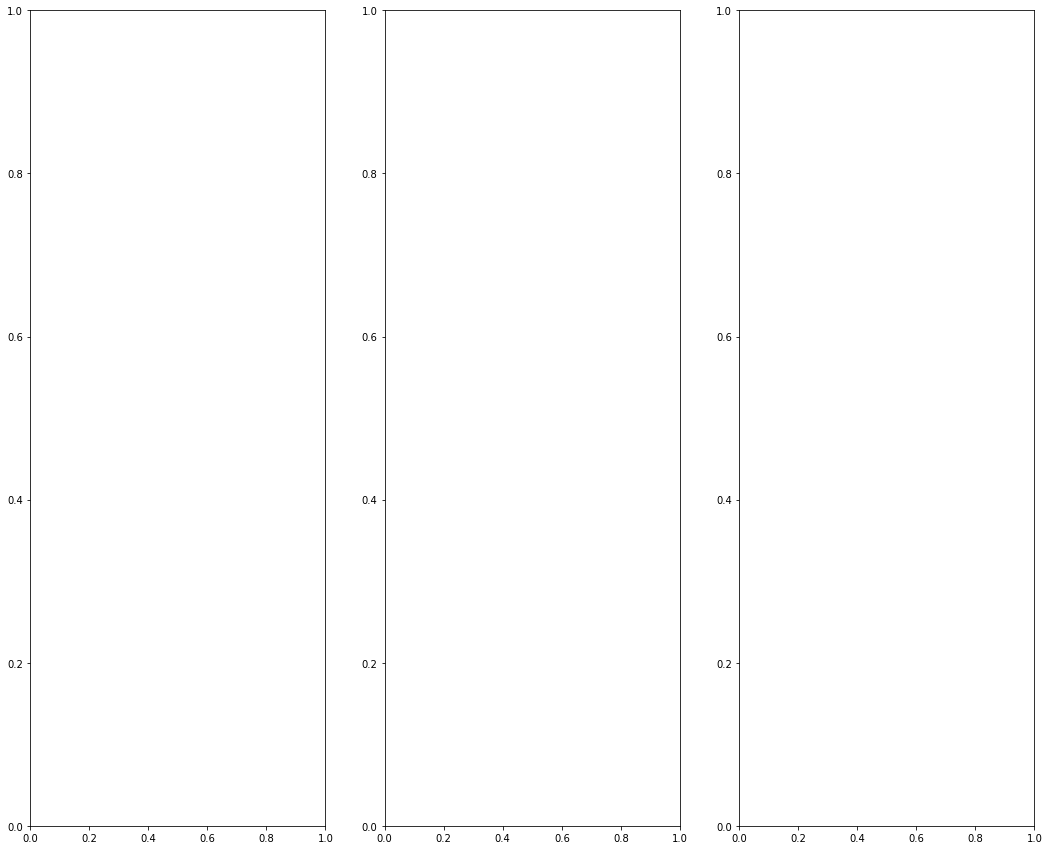

In [ ]:
X_3 = tr[['lat', 'lon']].values
ks = range(1, 3)
k_sample = [10, 13, 16]

kmean = [cluster.KMeans(n_clusters=i).fit(X_3) for i in ks]
n = len(k_sample)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

In [ ]:
n

3

In [ ]:
for i in range(n):
  print(i)
  kkkkkk = cluster.KMeans(n_clusters=k[i]).fit(X_3)

0
1
2


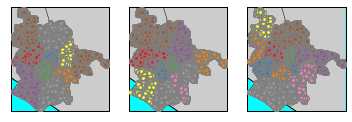

In [ ]:
for i in range(n):
  est = cluster.KMeans(n_clusters=k_sample[i]).fit(X_3)
  tr['cluster'] = est.predict(X_3).tolist()
    
  ax = plt.subplot(1, 3, i+1)
  #ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))
  plot_stations_map(ax, tr)

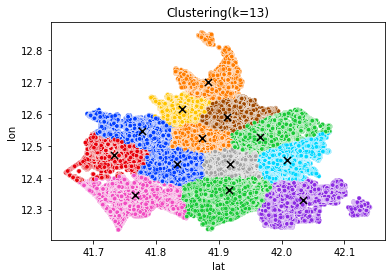

In [ ]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="lat", y="lon", data=tr, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")
fig.savefig('clusters.png', dpi= 500)
### remove the legend
## add to report
# figure of map of rome for the name of the clusters

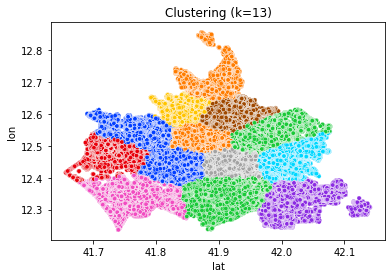

In [ ]:
k = tr["cluster"].nunique()
sns.scatterplot(x="lat", y="lon", data=tr, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False).set_title('Clustering (k='+str(k)+')')
fig.savefig('clusters_2.png', dpi= 500)


In [ ]:
x, y = "lat", "lon"
color = "cluster"
marker = "centroids"
size = 'Unnamed: 0'
data = tr.copy()
## create color column
lst_elements = sorted(list(tr[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)

## add centroids marker
lst_elements = sorted(list(tr[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_

https://github.com/gboeing/network-clustering/blob/main/network-clustering-simple.ipynb

In [ ]:
! pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.7 MB/s 
     |████████████████████████████████| 1.0 MB 52.3 MB/s 
     |████████████████████████████████| 11.2 MB 64.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 1.0 MB 63.7 MB/s 
     |████████████████████████████████| 16.7 MB 348 kB/s 
     |████████████████████████████████| 957 kB 59.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 12.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN

ox.config(use_cache=True, log_console=True)

In [ ]:
# parameterize DBSCAN
eps = 300 #meters
minpts = 3 #smallest cluster size allowed

# fake data: create n_firms evenly disbursed across n_clusters
#n_firms = 31635
n_firms = 30
n_clusters = 3

place = 'Rome, Italy'

In [ ]:
tr_one_percent = tr.sample(frac=0.001)
tr_one_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 55254 to 154938
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  411 non-null    int64  
 1   DESCRIZION  410 non-null    object 
 2   MUNICIPIO   411 non-null    float64
 3   CODICE_COM  411 non-null    int64  
 4   CODICE_PRO  411 non-null    int64  
 5   SCALA_NOMI  411 non-null    int64  
 6   DATA        411 non-null    object 
 7   CARTA       411 non-null    int64  
 8   DITTA       411 non-null    float64
 9   FLAG_LIM    69 non-null     float64
 10  IDENTIFICA  411 non-null    float64
 11  CODICE      411 non-null    object 
 12  CODICE_DGC  246 non-null    float64
 13  geometry    411 non-null    object 
 14  lon         411 non-null    float64
 15  lat         411 non-null    float64
 16  cluster     411 non-null    int32  
 17  centroids   411 non-null    int64  
dtypes: float64(7), int32(1), int64(6), object(4)
memory usage: 59.4

In [ ]:
G = ox.graph_from_place(place, network_type='drive', buffer_dist=500)

In [ ]:
X = list(tr_one_percent['lon'])
Y = list(tr_one_percent['lat'])

In [ ]:
center_node = []
for i in range(len(X)):
  if i % 100 == 0:
    print(i)  
  center_node.append(ox.distance.nearest_nodes(G, X[i], Y[i]))
print('node in a graph closest to the tree ',center_node)

0
100
200
300
400
node in a graph closest to the tree  [2068467005, 301487955, 301492441, 2086531093, 301034524, 2097770014, 303301012, 301490747, 308430227, 5336920282, 305937100, 1427471911, 309760602, 638787488, 266994890, 265750785, 259666053, 1764387453, 1591176059, 302195707, 1505782022, 2223515744, 1192539128, 297118915, 298309037, 302020563, 264630213, 122527182, 246067824, 251775428, 329725524, 1417100286, 259041313, 2945866352, 301027498, 331073444, 2103405869, 511108654, 4715263672, 6395195228, 2144299786, 317866601, 302980004, 304994725, 322361281, 331113174, 626942542, 1568429324, 874489892, 297106882, 307487674, 324804680, 8427005726, 308402760, 2446054854, 296261595, 302690182, 1568429289, 264485586, 307447388, 264261339, 313618028, 1445503699, 324812588, 626941981, 2101305335, 331072434, 309977710, 2295094037, 245784640, 1313919335, 332131212, 308086448, 615941768, 2069963696, 300137699, 2224735100, 3256621291, 310703186, 295718745, 4783328742, 247834135, 308427218, 329

In [ ]:
tr_one_percent["node"] = center_node

In [ ]:

# or just pick these three for consistency
firm_centers = [53145241, 260707482, 53059187] # center_node in our case

In [ ]:
print(len(center_node))

411


In [ ]:
n_firms = 411

In [ ]:
# scatter some firms around the selected nodes
xs = []
ys = []
for osmid in center_node:
    x = G.nodes[osmid]['x']
    y = G.nodes[osmid]['y']
    xs.extend(np.random.normal(loc=x, scale=1, size=1))
    ys.extend(np.random.normal(loc=y, scale=1, size=1))
print(len(xs))   
firms = pd.DataFrame({'x':xs, 'y':ys})

411


In [ ]:
firms

,x,y
0,14.381732,40.058119
1,13.215265,44.176542
2,14.139889,40.443121
3,11.851938,41.005696
4,12.710956,42.540070
...,...,...
406,12.426529,42.779438
407,13.515567,43.080930
408,12.193871,41.325017
409,14.103790,43.086700


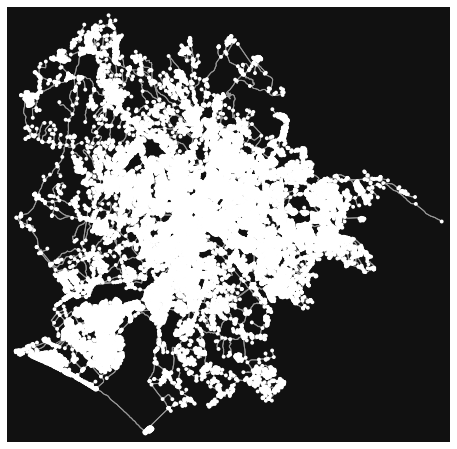

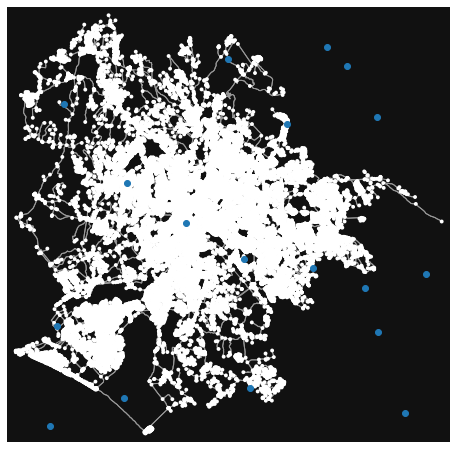

In [ ]:
# plot the firms and the points around which they cluster
fig, ax = ox.plot_graph(G)#, node_color='#aaaaaa', node_size=20, show=True, close=True)
ax.scatter(x=firms['x'], y=firms['y'], cmap='viridis')
fig.canvas.draw()
fig

In [ ]:
%%time
# compute DBSCAN using straight-line haversine distances
eps_rad = eps / 3671000. #meters to radians

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.54 µs


In [ ]:
db = DBSCAN(eps=eps_rad, min_samples=minpts, metric='haversine', algorithm='ball_tree')


In [ ]:
len(firms)

411

In [ ]:
firms['spatial_cluster'] = db.fit_predict(np.deg2rad(firms[['y', 'x']]))

In [ ]:
firms

,x,y,spatial_cluster
0,14.381732,40.058119,-1
1,13.215265,44.176542,-1
2,14.139889,40.443121,-1
3,11.851938,41.005696,-1
4,12.710956,42.540070,-1
...,...,...,...
406,12.426529,42.779438,-1
407,13.515567,43.080930,-1
408,12.193871,41.325017,-1
409,14.103790,43.086700,-1


In [ ]:
firms['spatial_cluster'].unique()

array([-1])

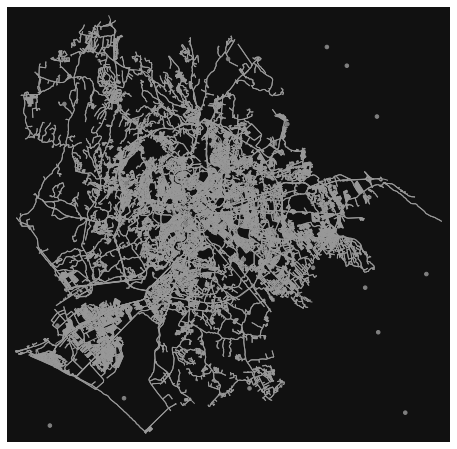

In [ ]:
# plot firms by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'m', 3:'b'}
point_colors = [color_map[c] for c in firms['spatial_cluster']]
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50)
fig.canvas.draw()
fig

In [ ]:
Gs = ox.utils_graph.get_largest_component(G, strongly=True) 

In [ ]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, vs=nodes_unique):
  G2 = G.copy()
  solved = False
  while not solved:
    try:
      dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
      result = pd.Series(dists, index=vs)
      return result
      solved = True
    except nx.exception.NetworkXNoPath:
      G2.remove_nodes_from([dist])


In [ ]:
# attach nearest network node to each firm
firms['nn'] = ox.get_nearest_nodes(G, X=firms['x'], Y=firms['y'], method='balltree')
print(len(firms['nn']))


# we'll get distances for each pair of nodes that have firms attached to them
nodes_unique = pd.Series(firms['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:426: UserWarning: The `get_nearest_nodes` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


411
44


In [ ]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
# create node-based distance matrix called node_dm
node_dm = nodes_unique.progress_apply(network_distance_matrix, G=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

  0%|          | 0/44 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)

NameError: ignored

In [ ]:
%%time
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

NetworkXNoPath: ignored

### DBSCAN Algorithm

https://medium.com/pythoneers/fully-explained-mean-shift-clustering-with-python-51aef7a17c5d

In [ ]:
%matplotlib inline
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.datasets import make_blobs

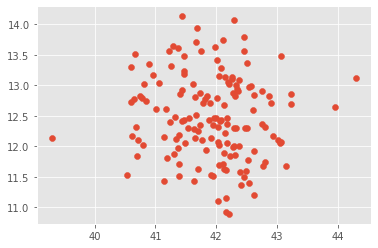

In [ ]:

position = tj[["lat","lon"]]
X_2,_=make_blobs(n_samples=150,centers=position,cluster_std=0.70)
plt.scatter(X_2[:,0],X_2[:,1])
plt.show()

In [ ]:
ms = MeanShift()
ms.fit(X_2)
labels = ms.labels_

[[41.98525454 12.37597504]
 [44.12873851 12.87892392]
 [39.295466   12.14223791]]
Estimated clusters: 3


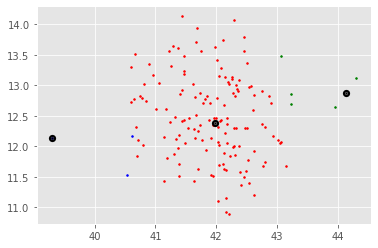

In [ ]:
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
for i in range(len(X_2)):
    plt.plot(X_2[i][0], X_2[i][1], colors[labels[i]], markersize = 3)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
           marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

https://towardsdatascience.com/clustering-in-geospatial-applications-which-model-should-you-use-59a039332c45

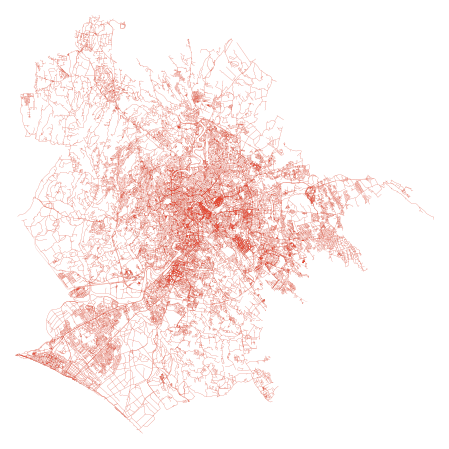

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6e924a9a50>)

In [ ]:
import osmnx as ox
place='Rome, Italy'
G = ox.graph_from_place(place)
ox.plot.plot_graph(G,edge_linewidth=0.1,edge_color='C0',node_size=0,bgcolor='w',save=True, filepath='Manhattan.png')

In [ ]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_1)
distances, indices = nbrs.kneighbors(np.radians(X_G3))
distances = distances[:, 1]
distances = np.sort(distances, axis=0)
fig=plt.figure()
plt.plot(distances)
plt.xlim(15000, 19000)
plt.ylim(.000001, .00002)
plt.ylabel(‘5-NN Distance (Radians)’)
plt.xlabel(‘Points Sorted By Distance’)
plt.savefig(‘dbscan_elbow’,dpi=600)
model = DBSCAN(eps=0.000005, min_samples=5, algorithm=’ball_tree’, metric=’haversine’).fit(np.radians(X_G3))
dbe_labels = model.labels_
#db_labels = np.unique(model_labels[model_labels >= 0])
nc_dbe,ns_dbe=plot1(G, ids_G3, dbe_labels,’dbscan_elbow_G.png’)

NameError: ignored

#TRYING MANHATTAN JUST TO SEE IF IT WORKS

https://towardsdatascience.com/clustering-in-geospatial-applications-which-model-should-you-use-59a039332c45

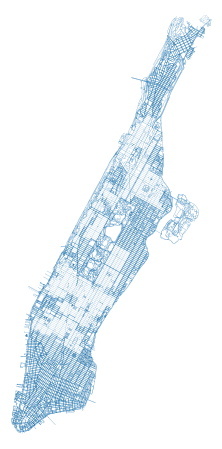

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff22e72a290>)

In [ ]:
import osmnx as ox
place='Manhattan, New York City, New York, USA'
G = ox.graph_from_place(place)
ox.plot.plot_graph(G,edge_linewidth=0.1,edge_color='C0',node_size=0,bgcolor='w',save=True, filepath='Manhattan.png')

In [ ]:
w = np.where(G == np.max(G))[0][0]
G2 = G.copy()
G2.remove_nodes_from(nodes_G[0:int(w*100)])
conn = nx.weakly_connected_components(G2)
conn_list = list(conn)
conn_list = sorted(conn_list, key=len, reverse=True)
G3 = G2.copy()
for i in range(0, len(conn_list) - 3):
 G3.remove_nodes_from(conn_list[i + 3])
X_G3 = [[G3.nodes[node]['y'], G3.nodes[node]['x']] for node in G3.nodes]
ids_G3 = [list(G3.nodes())[i] for i in range(0, len(list(G3.nodes())))]
labels=np.zeros(len(ids_G3))
for i in range(0,len(ids_G3)):
  if(ids_G3[i] in conn_list[0]):
    labels[i]=0
  if(ids_G3[i] in conn_list[1]):
    labels[i]=1
  if(ids_G3[i] in conn_list[2]):
    labels[i]=2
nc_g,ns_g=plot1(G,ids_G3,labels,'ground_truth.png')


NameError: ignored